In [1]:
from itertools import islice

# import multiprocessing
# multiprocessing.set_start_method('fork')

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.classes.function import path_weight
from scipy.optimize import curve_fit

import tqdm

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()


def sp(ns, W):
    G = nx.grid_2d_graph(3, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (2, ns)

    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = W[i]
        
    # plt.figure(figsize=(12, 8))
    # pos = dict(zip(G, G))
    # nx.draw(G, pos=pos, with_labels=True)
    # edge_labels = nx.get_edge_attributes(G, "weight")
    # nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")
#     dH = compute_dH(p0, p1, G)

    return delta # , dH

In [3]:
ns_max_c = 12

to_compute = False
if to_compute:
    M = 100000

    df = np.zeros((ns_max_c, 2))
    for ns in range(1, ns_max_c+1):
        N = 5*ns + 2
        dfM = np.zeros(M)
        W = np.random.rand(N, M)
        for m in tqdm.tqdm(range(M)):
            dfM[m] = sp(ns, W[:, m])
        df[ns-1] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    np.save("data/doubleRow/deltaF.npy", df)
    
delta_f = np.load("data/doubleRow/deltaF.npy")

[0.2350675  0.10166828 1.59648538 1.11818341]


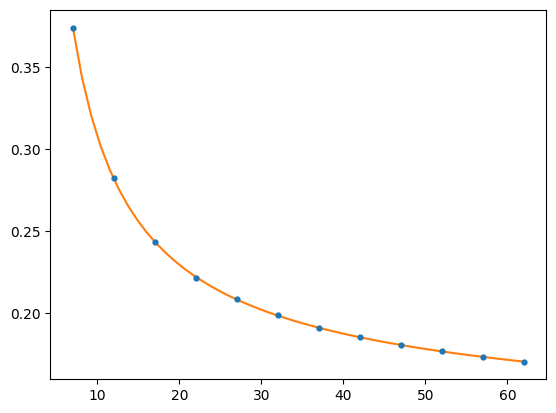

In [4]:
f_fit = lambda x, a, b, c, d: a / x**b + c / x**d

N = [5*ns + 2 for ns in range(1, ns_max_c+1)]
x = np.linspace(N[0], max(N))

plt.errorbar(N, delta_f[:, 0], yerr=delta_f[:, 1], fmt=".", ms=7, label="$\Delta_f$")
popt, pcov = curve_fit(f_fit, N, delta_f[:, 0], sigma=delta_f[:, 1], p0=[0.5, 0.5, 1, 1], 
                       bounds=[(0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)], maxfev=10000)
plt.plot(x, f_fit(x, *popt))
print(popt)

In [5]:
import h5py

ns_max = 8
sc = np.zeros((ns_max, 2))
dmin = np.zeros((ns_max, 2))

for ns in range(ns_max):
    f = h5py.File(f"data/doubleRow/A=N/ns={ns+1}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    
    M = scM.shape[0]
    print(M)
    
    sc[ns] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M)
    dmin[ns] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)

10000
10000
10000
2500
2500
1000
1000
258


In [6]:
N = np.array([5*ns+2 for ns in range(1, ns_max_c+1)])

B = 1
A = N.copy()

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

[6.41630027e-01 1.10693460e+00 6.83941933e-19]
[8.64308777e-01 1.23977846e+00 1.86464139e-13]


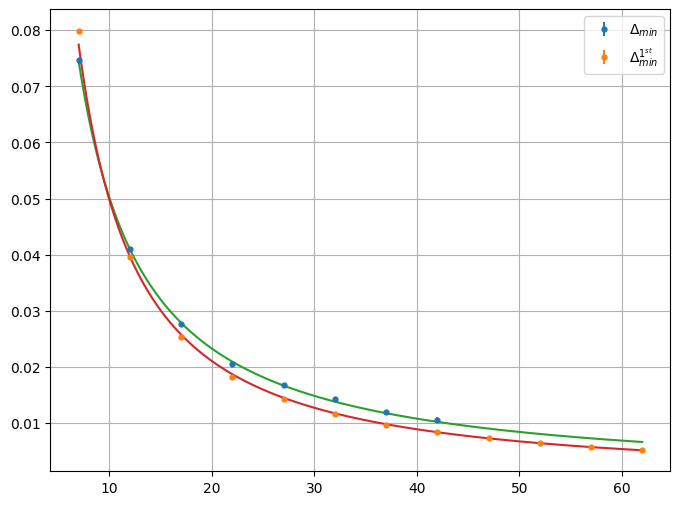

In [7]:
f_fit = lambda x, a, b, c: a / (x**b + c)

N = [5*ns+2 for ns in range(1, ns_max_c+1)]

plt.figure(figsize=(8, 6))
plt.errorbar(N[:ns_max], dmin[:, 0], yerr=dmin[:ns_max, 1], fmt=".", ms=7, label="$\Delta_{min}$")
plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=7, label="$\Delta_{min}^{1^{st}}$")
# plt.errorbar(N[1:], dmin_eff[1:, 0], yerr=dmin_eff[1:, 1], fmt=".", ms=7, label="$\Delta_{min}^{eff}$")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N[0:ns_max], dmin[0:ns_max, 0], sigma=dmin[0:ns_max, 1], p0=[0.1, 1.2, 1],#, 0.1],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N, first_order[:, 0], sigma=first_order[:, 1], p0=[1, 1.2, 5],# 0.1],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)

plt.legend()
plt.grid()

1.3705243506213458 0.6711994108884322 0.05563260195607225 1.0829721549146381e-17


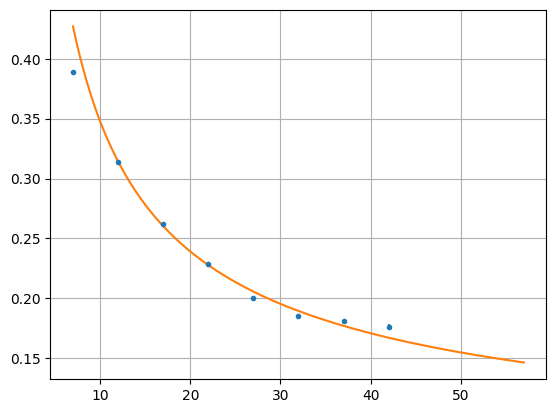

In [11]:
f_fit = lambda x, a, b, c, d: a / x**b + c / x**d

N = [5*ns+2 for ns in range(1, ns_max_c)]

plt.errorbar(N[:ns_max], sc[:, 0], fmt='.', yerr=sc[:, 1])
x = np.linspace(N[0], N[-1], 200)
popt, pcov = curve_fit(f_fit, N[1:ns_max], sc[1:ns_max, 0], sigma=sc[1:ns_max, 1], 
                       p0=[0.1, 1, 1, 1], bounds=[(0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)])
print(*popt)
plt.plot(x, f_fit(x, *popt))

plt.grid()